In [1]:
import pandas as pd
import numpy as np
import tarfile
from datetime import datetime
import pygeohash as pgh
import haversine as hs
from haversine import Unit
import pytz
import geopy.distance
import winsound

def alert():
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 1000  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)

# Data exploration

In [2]:
#peeking at a random data sample of new_abnovkak.txt
peek_1 = pd.read_csv('new_agdrea.txt', header=None, sep=' ')

In [3]:
peek_1.head()

,0,1,2,3
0,37.65060,-122.41837,0,1211035143
1,37.65059,-122.41832,0,1211035214
2,37.65060,-122.41833,0,1211035265
3,37.65063,-122.41836,0,1211035325
4,37.65063,-122.41838,0,1211035386


In [4]:
peek_1[3] = pd.to_datetime(peek_1[3], unit='s', utc=True).dt.tz_convert('America/Los_Angeles')

In [5]:
peek_1.head()

,0,1,2,3
0,37.65060,-122.41837,0,2008-05-17 07:39:03-07:00
1,37.65059,-122.41832,0,2008-05-17 07:40:14-07:00
2,37.65060,-122.41833,0,2008-05-17 07:41:05-07:00
3,37.65063,-122.41836,0,2008-05-17 07:42:05-07:00
4,37.65063,-122.41838,0,2008-05-17 07:43:06-07:00


In [6]:
peek_1.tail()

,0,1,2,3
23725,37.61763,-122.38505,0,2008-06-09 11:27:01-07:00
23726,37.61767,-122.38499,0,2008-06-09 11:28:01-07:00
23727,37.61764,-122.38730,0,2008-06-09 11:29:01-07:00
23728,37.61486,-122.39220,0,2008-06-09 11:30:01-07:00
23729,37.61574,-122.38810,0,2008-06-09 11:31:16-07:00


In [7]:
peek_1.dtypes

0                                float64
1                                float64
2                                  int64
3    datetime64[ns, America/Los_Angeles]
dtype: object

From this first peek, we can see that columns:
0: latitude; 1: longitude; 2: occupancy; 3: UNIX time with no timezone

It is seen that rows are sorted ascending by time (column index 3). Let's peek at a second file.

In [8]:
peek_2 = pd.read_csv('new_ayshowg.txt', header=None, sep=' ')

In [9]:
peek_2.head()

,0,1,2,3
0,37.72950,-122.43056,0,1211018452
1,37.73574,-122.42454,0,1211018512
2,37.73961,-122.42364,0,1211018576
3,37.74335,-122.42127,0,1211018632
4,37.74692,-122.41903,0,1211018705


In [10]:
peek_2.tail()

,0,1,2,3
7780,37.58710,-122.34678,0,1213037654
7781,37.59098,-122.36260,0,1213037698
7782,37.59941,-122.37542,0,1213037753
7783,37.60796,-122.38811,0,1213037791
7784,37.61564,-122.38822,0,1213037982


In [11]:
peek_2.dtypes

0    float64
1    float64
2      int64
3      int64
dtype: object

Same findings as in first peek. Now let's load the whole dataset.

In [12]:
tar_file = tarfile.open('cabspottingdata.tar.gz')

In [13]:
txt_files = [f.name for f in tar_file.getmembers() if f.name.endswith('.txt')]

In [14]:
#to get how many txt files have been read (it should be 537, as per visually/manually counted)
len(txt_files)

537

In [15]:
#creating functions to calculate distance, duration, speed and to create hash

def hash(x):
    return pgh.encode(x[0],x[1],precision=6)

def distance(x): #in miles
    coord1 = (x.latitude,x.longitude)
    coord2 = (x.prev_latitude,x.prev_longitude)
    dist = np.nan
    try:
        dist = geopy.distance.distance(coord1,coord2).miles
    except:
        pass
    return dist

def duration(x): #in hours
    return (x.time-x.prev_time)/3600*1.000

def speed(x): #in miles per hour
    speed = np.nan
    try:
        speed = x.distance/x.duration
    except:
        pass
    return speed

In [17]:
%%time

#converting the text files to pandas dataframes, and adding some necessary columns

df_array = []

for file in txt_files:
    
    #reading the txt file as pandas dataframe
    data = pd.read_csv(file,header=None,sep=' ')
    
    #adding cab_id column
    data['cab_id'] = file.split('/')[2]
    data['cab_id'] = data['cab_id'].str.replace('new_','')
    data['cab_id'] = data['cab_id'].str.replace('.txt','')
    
    #removing rows outside of geographic boundary
    upper_left = (37.50099307206452, -122.5040592173577)
    bottom_right = (37.05005488367874, -121.98034438258429)
    
    data.drop(data[data[0] < 37.05005488367874].index, inplace=True)
    data.drop(data[data[1] < -122.5040592173577].index, inplace=True)
    
    
    #making datetime, day of week, hour of day, and geohash columns
    data['datetime'] = pd.to_datetime(data[3], unit='s', utc=True).dt.tz_convert('America/Los_Angeles')
#     data['datetime'] = data[3].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    data['dow'] = data['datetime'].dt.weekday
#     data['dow'] = data[3].apply(lambda x: datetime.utcfromtimestamp(x).weekday())
    data['hod'] = data['datetime'].dt.hour
#     data['hod'] = data[3].apply(lambda x: datetime.utcfromtimestamp(x).hour)
    data['geohash'] = data.apply(hash,axis=1)
    
    #sorting dataframe by time
    data.sort_values(3,inplace=True)
    
    #after sorted by time, we can get the row-by-row previous values for duration, distance, and speed calculation 
    data['prev_latitude'] = data.groupby(['cab_id'])[0].shift()
    data['prev_longitude'] = data.groupby(['cab_id'])[1].shift()
    data['prev_time'] = data.groupby(['cab_id'])[3].shift()
    data['prev_dow'] = data.groupby(['cab_id'])['dow'].shift()
    data['prev_hour'] = data.groupby(['cab_id'])['hod'].shift()
    
    #appending 
    df_array.append(data)

Wall time: 5min 27s


In [19]:
#checking if array has same number of elements (it should be 537)
len(df_array)

537

In [20]:
#just to get a peek at one of the dataframes in the array
df_array[536].tail(50)

,0,1,2,3,cab_id,datetime,dow,hod,geohash,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour
22219,37.70789,-122.39480,0,1213033087,uvreoipy,2008-06-09 10:38:07-07:00,0,10,9q8ywb,37.69465,-122.39180,1.213033e+09,0.0,10.0
22220,37.72095,-122.40007,0,1213033128,uvreoipy,2008-06-09 10:38:48-07:00,0,10,9q8ywd,37.70789,-122.39480,1.213033e+09,0.0,10.0
22221,37.73351,-122.40562,0,1213033182,uvreoipy,2008-06-09 10:39:42-07:00,0,10,9q8ywt,37.72095,-122.40007,1.213033e+09,0.0,10.0
22222,37.74880,-122.40430,0,1213033292,uvreoipy,2008-06-09 10:41:32-07:00,0,10,9q8ywx,37.73351,-122.40562,1.213033e+09,0.0,10.0
22223,37.74858,-122.40748,0,1213033330,uvreoipy,2008-06-09 10:42:10-07:00,0,10,9q8ywx,37.74880,-122.40430,1.213033e+09,0.0,10.0
22224,37.74835,-122.41132,0,1213033359,uvreoipy,2008-06-09 10:42:39-07:00,0,10,9q8ywr,37.74858,-122.40748,1.213033e+09,0.0,10.0
22225,37.74831,-122.41349,0,1213033421,uvreoipy,2008-06-09 10:43:41-07:00,0,10,9q8ywr,37.74835,-122.41132,1.213033e+09,0.0,10.0
22226,37.74821,-122.41955,0,1213033475,uvreoipy,2008-06-09 10:44:35-07:00,0,10,9q8ywr,37.74831,-122.41349,1.213033e+09,0.0,10.0
22227,37.74791,-122.42394,0,1213033543,uvreoipy,2008-06-09 10:45:43-07:00,0,10,9q8ywp,37.74821,-122.41955,1.213033e+09,0.0,10.0
22228,37.74774,-122.42690,0,1213033567,uvreoipy,2008-06-09 10:46:07-07:00,0,10,9q8ywp,37.74791,-122.42394,1.213034e+09,0.0,10.0


In [21]:
#combining the list of dataframes to a single dataframe, and renaming some columns
combined_df = pd.DataFrame()
df = combined_df.append(df_array, True)
df = df.rename(columns={0:"latitude",1:"longitude",2:"occupancy",3:"time"})

In [22]:
#saving locally for future use
df.to_csv('combined.csv',index=False)

In [24]:
# df = pd.read_csv('combined.csv')

In [25]:
df.tail()

,latitude,longitude,occupancy,time,cab_id,datetime,dow,hod,geohash,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour
11189249,37.74654,-122.44338,1,1213035491,uvreoipy,2008-06-09 11:18:11-07:00,0,11,9q8ytx,37.74501,-122.44424,1.213035e+09,0.0,11.0
11189250,37.75140,-122.44296,1,1213035548,uvreoipy,2008-06-09 11:19:08-07:00,0,11,9q8yv8,37.74654,-122.44338,1.213035e+09,0.0,11.0
11189251,37.75686,-122.44239,1,1213035612,uvreoipy,2008-06-09 11:20:12-07:00,0,11,9q8yvc,37.75140,-122.44296,1.213036e+09,0.0,11.0
11189252,37.76047,-122.44215,1,1213035668,uvreoipy,2008-06-09 11:21:08-07:00,0,11,9q8yvf,37.75686,-122.44239,1.213036e+09,0.0,11.0
11189253,37.76075,-122.43687,1,1213035729,uvreoipy,2008-06-09 11:22:09-07:00,0,11,9q8yvf,37.76047,-122.44215,1.213036e+09,0.0,11.0


In [26]:
%%time
#creating duration, distance, and speed columns
df['duration'] = df.apply(duration, axis=1)
df['distance'] = df.apply(distance, axis=1)
df['speed'] = df.apply(speed, axis = 1)
alert()

Wall time: 43min 50s


In [27]:
#saving locally for future use
df.to_csv('calculated.csv',index=False)

In [ ]:
# df = pd.read_csv('calculated.csv')

In [28]:
df.tail()

,latitude,longitude,occupancy,time,cab_id,datetime,dow,hod,geohash,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour,duration,distance,speed
11189249,37.74654,-122.44338,1,1213035491,uvreoipy,2008-06-09 11:18:11-07:00,0,11,9q8ytx,37.74501,-122.44424,1.213035e+09,0.0,11.0,0.016111,0.115553,7.172267
11189250,37.75140,-122.44296,1,1213035548,uvreoipy,2008-06-09 11:19:08-07:00,0,11,9q8yv8,37.74654,-122.44338,1.213035e+09,0.0,11.0,0.015833,0.335968,21.219040
11189251,37.75686,-122.44239,1,1213035612,uvreoipy,2008-06-09 11:20:12-07:00,0,11,9q8yvc,37.75140,-122.44296,1.213036e+09,0.0,11.0,0.017778,0.377852,21.254166
11189252,37.76047,-122.44215,1,1213035668,uvreoipy,2008-06-09 11:21:08-07:00,0,11,9q8yvf,37.75686,-122.44239,1.213036e+09,0.0,11.0,0.015556,0.249318,16.027591
11189253,37.76075,-122.43687,1,1213035729,uvreoipy,2008-06-09 11:22:09-07:00,0,11,9q8yvf,37.76047,-122.44215,1.213036e+09,0.0,11.0,0.016944,0.289743,17.099568


In [29]:
df.describe()

,latitude,longitude,occupancy,time,dow,hod,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour,duration,distance,speed
count,1.118925e+07,1.118925e+07,1.118925e+07,1.118925e+07,1.118925e+07,1.118925e+07,1.118872e+07,1.118872e+07,1.118872e+07,1.118872e+07,1.118872e+07,1.118872e+07,1.118872e+07,1.118872e+07
mean,3.776347e+01,-1.224121e+02,4.473416e-01,1.212036e+09,3.185797e+00,1.253388e+01,3.776347e+01,-1.224121e+02,1.212036e+09,3.185926e+00,1.253401e+01,2.539242e-02,2.540274e-01,2.092766e+01
std,5.342377e-02,3.508617e-02,4.972194e-01,5.885492e+05,2.056311e+00,6.762166e+00,5.342228e-02,3.508516e-02,5.885236e+05,2.056257e+00,6.762212e+00,4.366744e-01,1.274472e+00,5.392003e+02
min,3.708165e+01,-1.225041e+02,0.000000e+00,1.211018e+09,0.000000e+00,0.000000e+00,3.708165e+01,-1.225041e+02,1.211018e+09,0.000000e+00,0.000000e+00,2.777778e-04,0.000000e+00,0.000000e+00
25%,3.775503e+01,-1.224251e+02,0.000000e+00,1.211523e+09,1.000000e+00,7.000000e+00,3.775503e+01,-1.224251e+02,1.211523e+09,1.000000e+00,7.000000e+00,1.444444e-02,2.016508e-02,1.749008e+00
50%,3.778109e+01,-1.224110e+02,0.000000e+00,1.212043e+09,3.000000e+00,1.300000e+01,3.778109e+01,-1.224110e+02,1.212043e+09,3.000000e+00,1.300000e+01,1.666667e-02,1.450966e-01,9.124998e+00
75%,3.779043e+01,-1.224002e+02,1.000000e+00,1.212549e+09,5.000000e+00,1.800000e+01,3.779043e+01,-1.224002e+02,1.212549e+09,5.000000e+00,1.800000e+01,1.722222e-02,2.856424e-01,1.712971e+01
max,5.030546e+01,-1.155622e+02,1.000000e+00,1.213090e+09,6.000000e+00,2.300000e+01,5.030546e+01,-1.155622e+02,1.213090e+09,6.000000e+00,2.300000e+01,4.135228e+02,8.764583e+02,1.554486e+06


<AxesSubplot:xlabel='distance', ylabel='duration'>

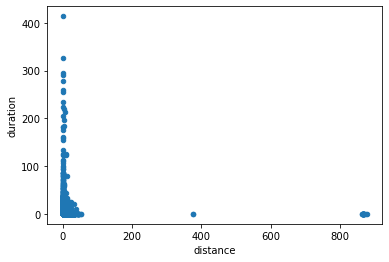

In [30]:
#plotting distance vs duration
df.plot.scatter('distance','duration')

<AxesSubplot:xlabel='distance', ylabel='duration'>

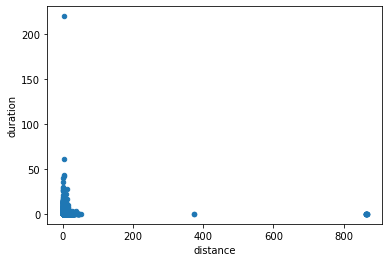

In [31]:
#plotting distance vs duration when rides
df[df['occupancy']==1].plot.scatter('distance','duration')

<AxesSubplot:xlabel='distance', ylabel='duration'>

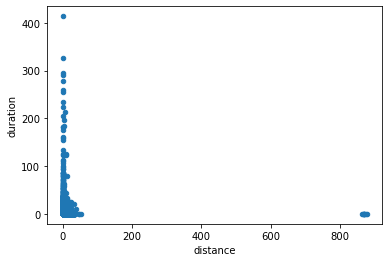

In [32]:
#plotting distance vs duration of idle roams
df[df['occupancy']==0].plot.scatter('distance','duration')

<AxesSubplot:xlabel='distance', ylabel='speed'>

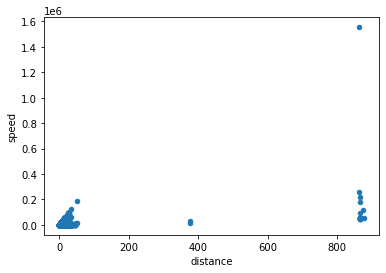

In [33]:
#plotting distance vs speed of idle roams
df.plot.scatter('distance','speed')

<AxesSubplot:xlabel='distance', ylabel='speed'>

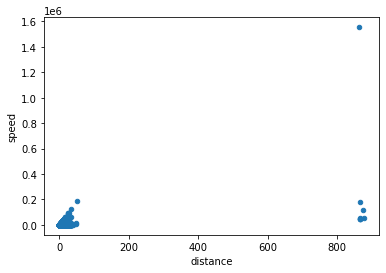

In [34]:
#plotting distance vs speed of idle roams
df[df['occupancy']==0].plot.scatter('distance','speed')

<AxesSubplot:xlabel='distance', ylabel='speed'>

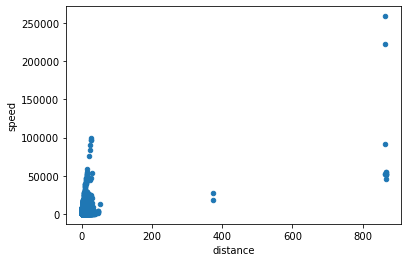

In [35]:
#plotting distance vs speed of rides
df[df['occupancy']==1].plot.scatter('distance','speed')

We can see that there are datapoints where vehicle speed is irrational. From this website, https://www.iihs.org/topics/speed/speed-limit-laws it is shown that the highest speed limit in California is 70 mph. Let's assume that people may push it to 80 mph. So we will exclude all datapoints with speed above 80 mph

In [67]:
#removing all speed above 80mph
df_cleaned = df[df['speed']<= 80]

<AxesSubplot:xlabel='distance', ylabel='speed'>

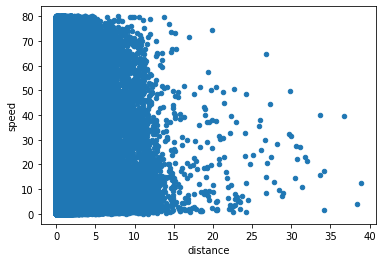

In [68]:
#plotting distance vs speed of rides
df_cleaned.plot.scatter('distance','speed')

<AxesSubplot:xlabel='duration', ylabel='speed'>

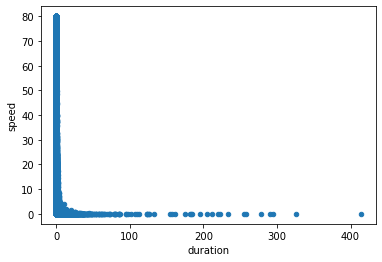

In [69]:
#plotting duration vs speed of rides
df_cleaned.plot.scatter('duration','speed')

<AxesSubplot:xlabel='distance', ylabel='speed'>

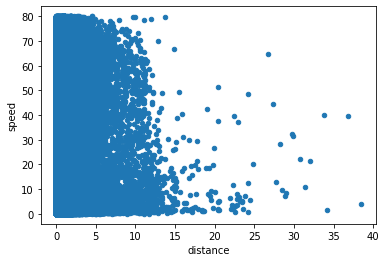

In [39]:
#plotting distance vs speed of idle roams
df_cleaned[df_cleaned['occupancy']==0].plot.scatter('distance','speed')

<AxesSubplot:xlabel='duration', ylabel='speed'>

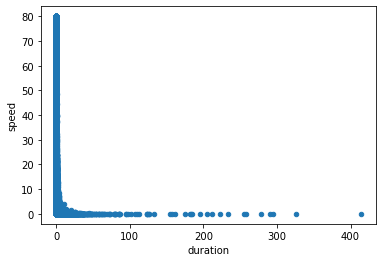

In [40]:
#plotting duration vs speed of idle roams
df_cleaned[df_cleaned['occupancy']==0].plot.scatter('duration','speed')

<AxesSubplot:ylabel='Frequency'>

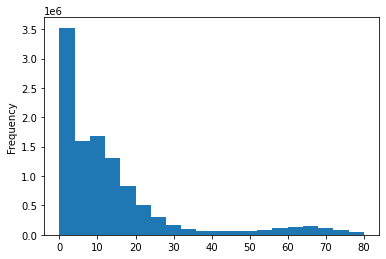

In [41]:
df_cleaned['speed'].plot.hist(bins=20)

In [70]:
from scipy import stats

In [71]:
#cleaning outliers
df_cleansed = df_cleaned[(np.abs(stats.zscore(df_cleaned['distance'])) < 3)]
df_cleansed = df_cleansed[(np.abs(stats.zscore(df_cleansed['duration'])) < 3)]
df_cleansed = df_cleansed[(np.abs(stats.zscore(df_cleansed['speed'])) < 3)]

In [72]:
#and adding date column
df_cleansed['date']= pd.to_datetime(df_cleansed['datetime'], format='%Y-%m-%d %H:%M:%S').dt.date

<AxesSubplot:xlabel='distance', ylabel='speed'>

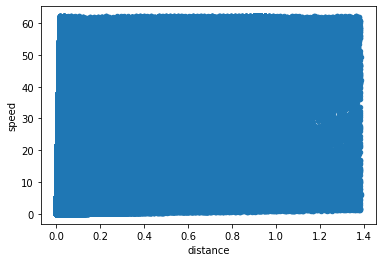

In [73]:
df_cleansed[df_cleansed['occupancy']==0].plot.scatter('distance','speed')

<AxesSubplot:xlabel='distance', ylabel='duration'>

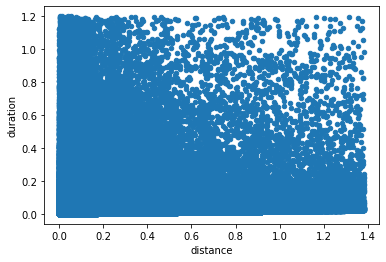

In [74]:
df_cleansed[df_cleansed['occupancy']==0].plot.scatter('distance','duration')

<AxesSubplot:xlabel='distance', ylabel='speed'>

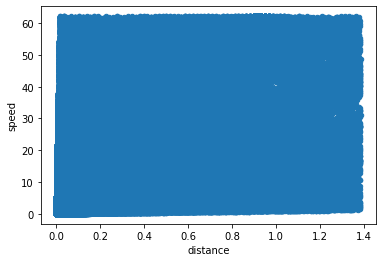

In [75]:
df_cleansed[df_cleansed['occupancy']==1].plot.scatter('distance','speed')

<AxesSubplot:xlabel='distance', ylabel='duration'>

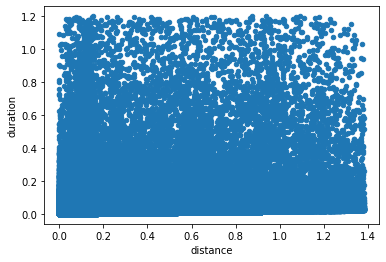

In [76]:
df_cleansed[df_cleansed['occupancy']==1].plot.scatter('distance','duration')

In [77]:
print(len(df_cleansed.index))

10488299


<AxesSubplot:xlabel='distance', ylabel='duration'>

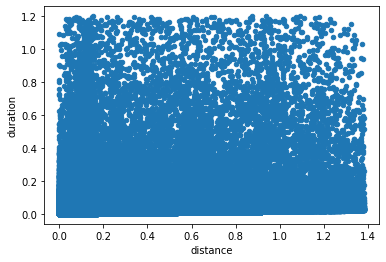

In [78]:
df_cleansed[df_cleansed['occupancy']==1].plot.scatter('distance','duration')

In [79]:
df_cleansed.head()

,latitude,longitude,occupancy,time,cab_id,datetime,dow,hod,geohash,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour,duration,distance,speed,date
1,37.75149,-122.39447,0,1211033614,abboip,2008-05-17 07:13:34-07:00,5,7,9q8yyb,37.75153,-122.39447,1.211034e+09,5.0,7.0,0.023333,0.002759,0.118229,2008-05-17
2,37.75149,-122.39447,0,1211033674,abboip,2008-05-17 07:14:34-07:00,5,7,9q8yyb,37.75149,-122.39447,1.211034e+09,5.0,7.0,0.016667,0.000000,0.000000,2008-05-17
3,37.75149,-122.39446,0,1211033735,abboip,2008-05-17 07:15:35-07:00,5,7,9q8yyb,37.75149,-122.39447,1.211034e+09,5.0,7.0,0.016944,0.000548,0.032318,2008-05-17
4,37.75144,-122.39449,0,1211035303,abboip,2008-05-17 07:41:43-07:00,5,7,9q8yyb,37.75149,-122.39446,1.211034e+09,5.0,7.0,0.435556,0.003820,0.008770,2008-05-17
5,37.75151,-122.39453,0,1211035374,abboip,2008-05-17 07:42:54-07:00,5,7,9q8yyb,37.75144,-122.39449,1.211035e+09,5.0,7.0,0.019722,0.005301,0.268802,2008-05-17


<AxesSubplot:ylabel='Frequency'>

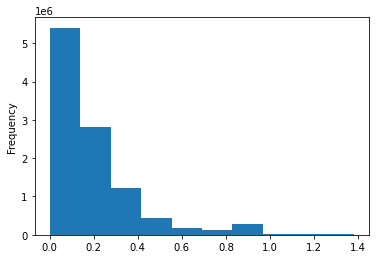

In [80]:
df_cleansed['distance'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

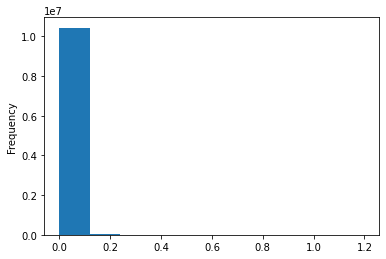

In [81]:
df_cleansed['duration'].plot.hist()

In [82]:
df_cleansed.describe()

,latitude,longitude,occupancy,time,dow,hod,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour,duration,distance,speed
count,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07,1.048830e+07
mean,3.776786e+01,-1.224139e+02,4.404089e-01,1.212036e+09,3.196679e+00,1.254503e+01,3.776784e+01,-1.224139e+02,1.212036e+09,3.196772e+00,1.254653e+01,1.797326e-02,1.814116e-01,1.095833e+01
std,4.691401e-02,3.181085e-02,4.964362e-01,5.879059e+05,2.052013e+00,6.774265e+00,4.694110e-02,3.185562e-02,5.879055e+05,2.051904e+00,6.770974e+00,2.953675e-02,2.065949e-01,1.201818e+01
min,3.712274e+01,-1.225041e+02,0.000000e+00,1.211018e+09,0.000000e+00,0.000000e+00,3.713487e+01,-1.225041e+02,1.211018e+09,0.000000e+00,0.000000e+00,2.777778e-04,0.000000e+00,0.000000e+00
25%,3.776190e+01,-1.224259e+02,0.000000e+00,1.211523e+09,1.000000e+00,7.000000e+00,3.776187e+01,-1.224259e+02,1.211523e+09,1.000000e+00,7.000000e+00,1.527778e-02,1.464706e-02,1.324028e+00
50%,3.778241e+01,-1.224123e+02,0.000000e+00,1.212043e+09,3.000000e+00,1.300000e+01,3.778241e+01,-1.224123e+02,1.212043e+09,3.000000e+00,1.300000e+01,1.666667e-02,1.315543e-01,8.340274e+00
75%,3.779083e+01,-1.224014e+02,1.000000e+00,1.212547e+09,5.000000e+00,1.800000e+01,3.779084e+01,-1.224014e+02,1.212547e+09,5.000000e+00,1.800000e+01,1.722222e-02,2.535218e-01,1.522594e+01
max,3.799999e+01,-1.220000e+02,1.000000e+00,1.213090e+09,6.000000e+00,2.300000e+01,3.799999e+01,-1.220000e+02,1.213090e+09,6.000000e+00,2.300000e+01,1.197500e+00,1.382620e+00,6.214469e+01


In [83]:
df_idle = df_cleansed[df_cleansed['occupancy']==0]

In [84]:
df_idle.head()

,latitude,longitude,occupancy,time,cab_id,datetime,dow,hod,geohash,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour,duration,distance,speed,date
1,37.75149,-122.39447,0,1211033614,abboip,2008-05-17 07:13:34-07:00,5,7,9q8yyb,37.75153,-122.39447,1.211034e+09,5.0,7.0,0.023333,0.002759,0.118229,2008-05-17
2,37.75149,-122.39447,0,1211033674,abboip,2008-05-17 07:14:34-07:00,5,7,9q8yyb,37.75149,-122.39447,1.211034e+09,5.0,7.0,0.016667,0.000000,0.000000,2008-05-17
3,37.75149,-122.39446,0,1211033735,abboip,2008-05-17 07:15:35-07:00,5,7,9q8yyb,37.75149,-122.39447,1.211034e+09,5.0,7.0,0.016944,0.000548,0.032318,2008-05-17
4,37.75144,-122.39449,0,1211035303,abboip,2008-05-17 07:41:43-07:00,5,7,9q8yyb,37.75149,-122.39446,1.211034e+09,5.0,7.0,0.435556,0.003820,0.008770,2008-05-17
5,37.75151,-122.39453,0,1211035374,abboip,2008-05-17 07:42:54-07:00,5,7,9q8yyb,37.75144,-122.39449,1.211035e+09,5.0,7.0,0.019722,0.005301,0.268802,2008-05-17


In [85]:
df_rides = df_cleansed[df_cleansed['occupancy']==1]

In [86]:
df_rides.head()

,latitude,longitude,occupancy,time,cab_id,datetime,dow,hod,geohash,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour,duration,distance,speed,date
14,37.74977,-122.39724,1,1211035870,abboip,2008-05-17 07:51:10-07:00,5,7,9q8yyb,37.74978,-122.39709,1.211036e+09,5.0,7.0,0.007222,0.008243,1.141356,2008-05-17
15,37.74896,-122.40619,1,1211035931,abboip,2008-05-17 07:52:11-07:00,5,7,9q8ywx,37.74977,-122.39724,1.211036e+09,5.0,7.0,0.016944,0.493291,29.112275,2008-05-17
16,37.74831,-122.41335,1,1211036022,abboip,2008-05-17 07:53:42-07:00,5,7,9q8ywr,37.74896,-122.40619,1.211036e+09,5.0,7.0,0.025278,0.394653,15.612627,2008-05-17
17,37.75157,-122.41400,1,1211036082,abboip,2008-05-17 07:54:42-07:00,5,7,9q8yy2,37.74831,-122.41335,1.211036e+09,5.0,7.0,0.016667,0.227633,13.657972,2008-05-17
18,37.75552,-122.41438,1,1211036158,abboip,2008-05-17 07:55:58-07:00,5,7,9q8yy3,37.75157,-122.41400,1.211036e+09,5.0,7.0,0.021111,0.273214,12.941700,2008-05-17


In [87]:
print(str(min(df_cleansed['datetime']))+" "+str(max(df_cleansed['datetime'])))

2008-05-17 03:00:09-07:00 2008-06-10 02:25:34-07:00


In [88]:
df_idle['date']= pd.to_datetime(df_idle['datetime'], format='%Y-%m-%d %H:%M:%S').dt.date

<ipython-input-88-cf10af45ed96>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idle['date']= pd.to_datetime(df_idle['datetime'], format='%Y-%m-%d %H:%M:%S').dt.date


In [89]:
df_rides['date']= pd.to_datetime(df_rides['datetime'], format='%Y-%m-%d %H:%M:%S').dt.date

<ipython-input-89-093ef8375677>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides['date']= pd.to_datetime(df_rides['datetime'], format='%Y-%m-%d %H:%M:%S').dt.date


In [90]:
df_idle['date'] = pd.to_datetime(df_idle['date'])
df_idle.head()

<ipython-input-90-4f88f45010f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idle['date'] = pd.to_datetime(df_idle['date'])


,latitude,longitude,occupancy,time,cab_id,datetime,dow,hod,geohash,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour,duration,distance,speed,date
1,37.75149,-122.39447,0,1211033614,abboip,2008-05-17 07:13:34-07:00,5,7,9q8yyb,37.75153,-122.39447,1.211034e+09,5.0,7.0,0.023333,0.002759,0.118229,2008-05-17
2,37.75149,-122.39447,0,1211033674,abboip,2008-05-17 07:14:34-07:00,5,7,9q8yyb,37.75149,-122.39447,1.211034e+09,5.0,7.0,0.016667,0.000000,0.000000,2008-05-17
3,37.75149,-122.39446,0,1211033735,abboip,2008-05-17 07:15:35-07:00,5,7,9q8yyb,37.75149,-122.39447,1.211034e+09,5.0,7.0,0.016944,0.000548,0.032318,2008-05-17
4,37.75144,-122.39449,0,1211035303,abboip,2008-05-17 07:41:43-07:00,5,7,9q8yyb,37.75149,-122.39446,1.211034e+09,5.0,7.0,0.435556,0.003820,0.008770,2008-05-17
5,37.75151,-122.39453,0,1211035374,abboip,2008-05-17 07:42:54-07:00,5,7,9q8yyb,37.75144,-122.39449,1.211035e+09,5.0,7.0,0.019722,0.005301,0.268802,2008-05-17


In [91]:
df_rides['date'] = pd.to_datetime(df_rides['date'])
df_rides.head()

<ipython-input-91-ca774426a742>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides['date'] = pd.to_datetime(df_rides['date'])


,latitude,longitude,occupancy,time,cab_id,datetime,dow,hod,geohash,prev_latitude,prev_longitude,prev_time,prev_dow,prev_hour,duration,distance,speed,date
14,37.74977,-122.39724,1,1211035870,abboip,2008-05-17 07:51:10-07:00,5,7,9q8yyb,37.74978,-122.39709,1.211036e+09,5.0,7.0,0.007222,0.008243,1.141356,2008-05-17
15,37.74896,-122.40619,1,1211035931,abboip,2008-05-17 07:52:11-07:00,5,7,9q8ywx,37.74977,-122.39724,1.211036e+09,5.0,7.0,0.016944,0.493291,29.112275,2008-05-17
16,37.74831,-122.41335,1,1211036022,abboip,2008-05-17 07:53:42-07:00,5,7,9q8ywr,37.74896,-122.40619,1.211036e+09,5.0,7.0,0.025278,0.394653,15.612627,2008-05-17
17,37.75157,-122.41400,1,1211036082,abboip,2008-05-17 07:54:42-07:00,5,7,9q8yy2,37.74831,-122.41335,1.211036e+09,5.0,7.0,0.016667,0.227633,13.657972,2008-05-17
18,37.75552,-122.41438,1,1211036158,abboip,2008-05-17 07:55:58-07:00,5,7,9q8yy3,37.75157,-122.41400,1.211036e+09,5.0,7.0,0.021111,0.273214,12.941700,2008-05-17


In [92]:
alert()

# Analysis

In [93]:
idle_miles = df_idle[['date','distance']].groupby(['date']).sum().reset_index().set_index('date')

In [94]:
idle_miles.dtypes

distance    float64
dtype: object

<AxesSubplot:xlabel='date'>

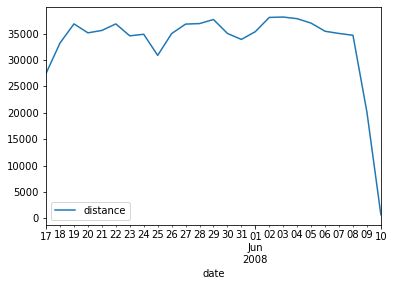

In [95]:
idle_miles.plot.line()

In [96]:
#removing 2008-05-17 and 2008-06-10 because they are not full days
idle_miles = idle_miles[idle_miles.index>datetime(2008,5,17)]
idle_miles = idle_miles[idle_miles.index<datetime(2008,6,10)]

<AxesSubplot:xlabel='date'>

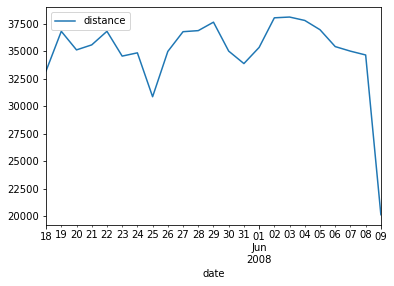

In [97]:
idle_miles.plot.line()

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

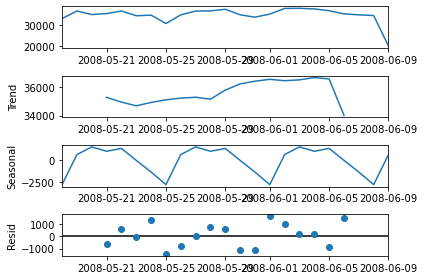

In [99]:
result = seasonal_decompose(idle_miles, model='additive')
result.plot()
pyplot.show()

There are seasonal/cyclical and up-trend in the data. However the time frame coverage of the data is limited only less than a month. So if we are to analyze into one year timeframe, the trend maybe inacurate to be projected to a longer timeframe like one year. However the seasonal which is weekly, is an insight for predictive model: day of week should be considered.

In [100]:
rides_miles = df_rides[['date','distance']].groupby(['date']).sum().reset_index().set_index('date')

In [101]:
rides_miles.dtypes

distance    float64
dtype: object

<AxesSubplot:xlabel='date'>

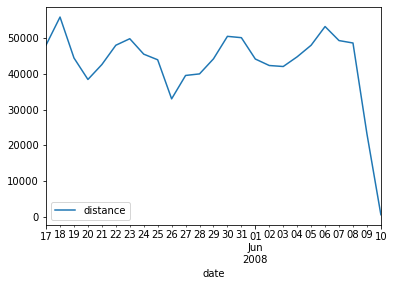

In [102]:
rides_miles.plot.line()

In [103]:
#removing 2008-05-17 and 2008-06-10 because they are not full days
rides_miles = rides_miles[rides_miles.index>datetime(2008,5,17)]
rides_miles = rides_miles[rides_miles.index<datetime(2008,6,10)]

<AxesSubplot:xlabel='date'>

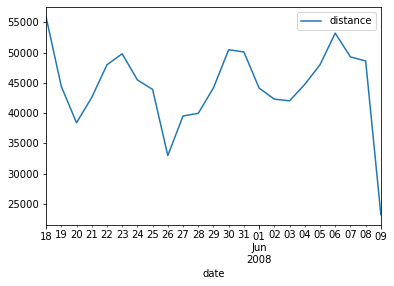

In [104]:
rides_miles.plot.line()

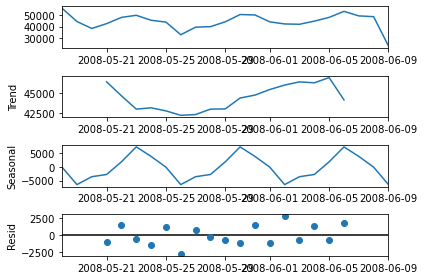

In [105]:
result = seasonal_decompose(rides_miles, model='additive')
result.plot()
pyplot.show()

In [106]:
cab_rides = df_cleansed[['cab_id','date','distance']][df['occupancy']==1].groupby(['cab_id','date']).sum().reset_index().set_index(['cab_id','date'])

<ipython-input-106-6a4b7ec96455>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cab_rides = df_cleansed[['cab_id','date','distance']][df['occupancy']==1].groupby(['cab_id','date']).sum().reset_index().set_index(['cab_id','date'])


In [107]:
cab_rides.head()

distance
cab_id date                  
abboip 2008-05-17  100.501729
       2008-05-18   75.164261
       2008-05-19   99.338733
       2008-05-20  119.588223
       2008-05-21   13.778886

In [108]:
cab_idles = df_cleansed[['cab_id','date','distance']][df['occupancy']==0].groupby(['cab_id','date']).sum().reset_index().set_index(['cab_id','date'])

<ipython-input-108-fbb936c2449d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cab_idles = df_cleansed[['cab_id','date','distance']][df['occupancy']==0].groupby(['cab_id','date']).sum().reset_index().set_index(['cab_id','date'])


In [109]:
cab_idles.tail()

distance
cab_id   date                  
uvreoipy 2008-06-05   93.411747
         2008-06-06   87.803069
         2008-06-07   69.601399
         2008-06-08  138.657739
         2008-06-09   39.140974

In [110]:
cab_rides.describe()

,distance
count,11832.000000
mean,90.431401
std,31.862285
min,0.000000
25%,71.538267
50%,93.438843
75%,112.109282
max,192.943036


In [111]:
cab_idles.describe()

,distance
count,11920.000000
mean,69.858595
std,26.001069
min,0.000000
25%,53.855384
50%,71.503395
75%,87.898291
max,160.730261


Need to find miles per cab per day (rides, idle, and total)

In [112]:
#concatenating cab dataframes
cab_rides.rename(columns={'distance':'rides_miles'},inplace=True)
cab_idles.rename(columns={'distance':'idle_miles'},inplace=True)
cab_df = pd.concat([cab_rides,cab_idles],axis=1)

In [113]:
cab_df.tail(50)

rides_miles  idle_miles
cab_id   date                               
uvjeahot 2008-06-04    76.168823   82.798511
         2008-06-05   116.156517   86.788768
         2008-06-06   107.682875   65.900696
         2008-06-07    89.872418   75.981890
         2008-06-08    51.587194   73.461647
         2008-06-09    20.963350   17.959768
uvjova   2008-05-17    51.096964   12.980811
         2008-05-18   121.119319   53.206775
         2008-05-19    58.360256   66.484677
         2008-05-20    78.761910   67.653436
         2008-05-21   109.147648   84.499685
         2008-05-22   134.027873   87.759958
         2008-05-23    78.612944   55.005081
         2008-05-24    22.325958   27.345788
         2008-05-25    15.889845    9.585784
         2008-05-26    50.953806   70.229999
         2008-05-28    67.790499  119.507201
         2008-05-29    13.077595   26.507151
         2008-05-30    92.270579   62.209240
         2008-05-31   105.968453   95.663117
         2008-06-01   106.145784   59.482393
         2008-06-02   101.836253  114.337601
         2008-06-03     7.782208   10.443919
         2008-06-06   119.962146  101.072968
         2008-06-07    96.963211   85.394579
         2008-06-08    57.626675    6.416297
uvreoipy 2008-05-17    84.224048   60.103019
         2008-05-18    86.241368   53.509756
         2008-05-19   103.728500   92.844463
         2008-05-20    80.676706   82.039634
         2008-05-21    88.229574   81.442495
         2008-05-22   116.892576   97.549968
         2008-05-23    91.245490   75.156234
         2008-05-24    77.540544   51.196455
         2008-05-25    61.811691   55.942962
         2008-05-26    59.146876   62.222839
         2008-05-27    89.994573   79.611931
         2008-05-28    72.663033   77.316301
         2008-05-29    91.428262   79.704540
         2008-05-30    89.952210   62.184776
         2008-05-31   110.168937   67.668939
         2008-06-01    62.996061   55.004348
         2008-06-02    97.972564   89.773190
         2008-06-03    90.070644   61.490240
         2008-06-04    97.065917   78.590225
         2008-06-05   100.802007   93.411747
         2008-06-06   104.687131   87.803069
         2008-06-07   100.395500   69.601399
         2008-06-08   101.692716  138.657739
         2008-06-09    17.646211   39.140974

In [114]:
daily_miles = cab_df.reset_index().drop(columns=['date','cab_id'])

In [115]:
daily_miles['total_miles'] = daily_miles.apply(lambda x: (x.rides_miles if ~np.isnan(x.rides_miles) else 0) + (x.idle_miles if ~np.isnan(x.idle_miles) else 0), axis=1)
daily_miles

,rides_miles,idle_miles,total_miles
0,100.501729,53.500660,154.002389
1,75.164261,40.359098,115.523360
2,99.338733,71.942030,171.280763
3,119.588223,147.831569,267.419792
4,13.778886,29.178797,42.957682
...,...,...,...
11915,100.802007,93.411747,194.213754
11916,104.687131,87.803069,192.490201
11917,100.395500,69.601399,169.996899
11918,101.692716,138.657739,240.350455


In [116]:
daily_miles.describe()

,rides_miles,idle_miles,total_miles
count,11832.000000,11920.000000,11920.000000
mean,90.431401,69.858595,159.622381
std,31.862285,26.001069,53.870859
min,0.000000,0.000000,0.002145
25%,71.538267,53.855384,130.214231
50%,93.438843,71.503395,167.738532
75%,112.109282,87.898291,196.691006
max,192.943036,160.730261,316.933200


<AxesSubplot:ylabel='Frequency'>

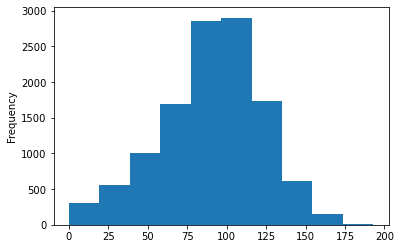

In [117]:
daily_miles['rides_miles'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

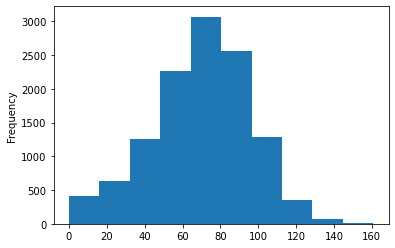

In [118]:
daily_miles['idle_miles'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

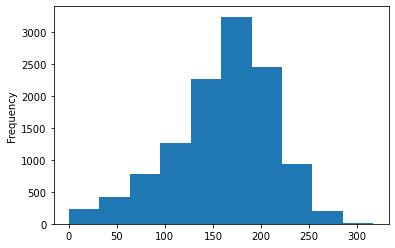

In [119]:
(daily_miles['rides_miles']+daily_miles['idle_miles']).plot.hist()

In [120]:
daily_miles.mean()

rides_miles     90.431401
idle_miles      69.858595
total_miles    159.622381
dtype: float64

In [121]:
#create 99% confidence interval for population total miles
stats.t.interval(alpha=0.99, df=len(daily_miles['total_miles'])-1, loc=np.mean(daily_miles['total_miles']), scale=stats.sem(daily_miles['total_miles']))

(158.35121504429497, 160.8935478710647)

In [122]:
#create 99% confidence interval for population rides miles
stats.t.interval(alpha=0.99, df=len(daily_miles['idle_miles'])-1, loc=np.mean(daily_miles['idle_miles']), scale=stats.sem(daily_miles['idle_miles']))

(69.24505924390381, 70.47213025979069)

In [123]:
alert()

## Prediction Model
Prediction model data structure: hour of day, day of week, geohash, rides (continuous label)

In [124]:
model_df = df_cleansed[['date','hod','dow','geohash','occupancy','duration','cab_id']]

In [125]:
model_df['idle_shifter'] = model_df['occupancy'].astype('str')+model_df['cab_id'].astype('str')+model_df['geohash'].astype('str')
model_df['rides_shifter'] = model_df['occupancy'].astype('str')+model_df['cab_id'].astype('str')

<ipython-input-125-3c5c6a386f90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['idle_shifter'] = model_df['occupancy'].astype('str')+model_df['cab_id'].astype('str')+model_df['geohash'].astype('str')
<ipython-input-125-3c5c6a386f90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['rides_shifter'] = model_df['occupancy'].astype('str')+model_df['cab_id'].astype('str')


In [126]:
model_df.tail()

,date,hod,dow,geohash,occupancy,duration,cab_id,idle_shifter,rides_shifter
11189249,2008-06-09,11,0,9q8ytx,1,0.016111,uvreoipy,1uvreoipy9q8ytx,1uvreoipy
11189250,2008-06-09,11,0,9q8yv8,1,0.015833,uvreoipy,1uvreoipy9q8yv8,1uvreoipy
11189251,2008-06-09,11,0,9q8yvc,1,0.017778,uvreoipy,1uvreoipy9q8yvc,1uvreoipy
11189252,2008-06-09,11,0,9q8yvf,1,0.015556,uvreoipy,1uvreoipy9q8yvf,1uvreoipy
11189253,2008-06-09,11,0,9q8yvf,1,0.016944,uvreoipy,1uvreoipy9q8yvf,1uvreoipy


In [127]:
model_df_rides = model_df.groupby((model_df['rides_shifter']!=model_df['rides_shifter'].shift()).cumsum()).first().reset_index(drop=True)
model_df_rides = model_df_rides[['hod','dow','geohash','occupancy']][model_df_rides['occupancy']==1].reset_index(drop=True)
# model_df_rides = model_df_rides.groupby(['hod','dow','geohash']).sum('occupancy').reset_index()

In [128]:
model_df_rides.head()

,hod,dow,geohash,occupancy
0,7,5,9q8yyb,1
1,8,5,9q8yy0,1
2,8,5,9q8yyk,1
3,8,5,9q8yyk,1
4,9,5,9q8yy2,1


In [129]:
model_df_rides.describe()

,hod,dow,occupancy
count,458794.000000,458794.000000,458794.0
mean,13.464505,3.354717,1.0
std,6.994589,2.028128,0.0
min,0.000000,0.000000,1.0
25%,9.000000,2.000000,1.0
50%,14.000000,4.000000,1.0
75%,20.000000,5.000000,1.0
max,23.000000,6.000000,1.0


In [130]:
model_df_idle = model_df.groupby((model_df['idle_shifter']!=model_df['idle_shifter'].shift()).cumsum()).first().reset_index(drop=True)
model_df_idle = model_df_idle[['hod','dow','geohash','occupancy']][model_df_idle['occupancy']==0].reset_index(drop=True)

In [131]:
# model_df_idle = model_df[model_df['occupancy']==0].groupby(['hod','dow','geohash','cab_id','occupancy']).sum('duration').reset_index()
# # model_df_idle = model_df_idle.groupby(['hod','dow','geohash','cab_id','occupancy'], sort=False)['duration'].max().reset_index()
# model_df_idle = model_df_idle.groupby(['hod','dow','geohash','occupancy'], sort=False)['duration'].max().reset_index()
# model_df_idle = model_df_idle[['hod','dow','geohash','occupancy']]

In [132]:
model_df_idle.tail()

,hod,dow,geohash,occupancy
2148804,10,0,9q8yvc,0
2148805,10,0,9q8yvf,0
2148806,11,0,9q8yvc,0
2148807,11,0,9q8yv8,0
2148808,11,0,9q8ytx,0


In [133]:
model_df_idle.describe()

,hod,dow,occupancy
count,2.148809e+06,2.148809e+06,2148809.0
mean,1.203736e+01,3.120670e+00,0.0
std,7.005726e+00,2.061690e+00,0.0
min,0.000000e+00,0.000000e+00,0.0
25%,6.000000e+00,1.000000e+00,0.0
50%,1.200000e+01,3.000000e+00,0.0
75%,1.800000e+01,5.000000e+00,0.0
max,2.300000e+01,6.000000e+00,0.0


In [134]:
# model_df = model_df.groupby((model_df['rides_shifter']!=model_df['rides_shifter'].shift()).cumsum()).first().reset_index(drop=True)
model_df_final = model_df_rides.append(model_df_idle).sample(frac=1).reset_index(drop=True)
#making geohash numerical categories
model_df_final['geohash_cat'] = pd.Categorical(model_df_final['geohash'])
model_df_final['geohash_cat'] = model_df_final['geohash_cat'].cat.codes

In [135]:
model_df_final.tail(20)

,hod,dow,geohash,occupancy,geohash_cat
2607583,19,5,9q8zn3,0,548
2607584,20,6,9q8zn0,1,545
2607585,4,0,9q8yy5,1,456
2607586,15,6,9q8yvf,1,388
2607587,15,0,9q8yyb,0,461
2607588,15,5,9q8yyw,0,479
2607589,4,6,9q8yyr,0,474
2607590,17,5,9q8yye,0,464
2607591,10,5,9q8zjc,0,512
2607592,14,5,9q8yyr,0,474


In [136]:
from collections import Counter
print(Counter(model_df_final['occupancy']))

Counter({0: 2148809, 1: 458794})


In [137]:
#we have imbalanced data. Let's undersample the idles
from imblearn.under_sampling import RandomUnderSampler

In [138]:
undersample = RandomUnderSampler(sampling_strategy = 'majority')

In [139]:
x_under, y_under = undersample.fit_resample(model_df_final[['hod','dow','geohash_cat']],model_df_final['occupancy'])

In [140]:
print(Counter(y_under))

Counter({0: 458794, 1: 458794})


In [157]:
train_samples = x_under
# train_samples = np.array(train_samples)
train_labels = y_under
# train_labels = np.array(train_labels)

In [158]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [159]:
x_train, x_test, y_train, y_test = train_test_split(train_samples,train_labels,test_size =0.2)
x_train

,hod,dow,geohash_cat
219508,21,2,424
60563,20,3,550
311938,18,6,470
856561,11,2,554
358048,18,4,451
...,...,...,...
284699,23,2,511
819070,17,6,479
722469,17,4,480
598460,19,3,482


In [160]:
model_nb = CategoricalNB()

In [161]:
%%time
model_nb.fit(x_train, y_train)

Wall time: 165 ms


CategoricalNB()

In [162]:
%%time
y_pred_nb = model_nb.predict(x_test)
print(y_pred_nb)
print(model_nb.score(x_test,y_test))

[1 1 1 ... 0 1 1]
0.6233012565524908
Wall time: 46.8 ms


In [163]:
model_lr = LogisticRegression()

In [164]:
%%time
model_lr.fit(x_train, y_train)

Wall time: 1.95 s


LogisticRegression()

In [165]:
%%time
y_pred_lr = model_lr.predict(x_test)
print(y_pred_lr)
print(model_lr.score(x_test,y_test))

[1 1 1 ... 0 1 1]
0.5463006353600192
Wall time: 26.9 ms


In [166]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

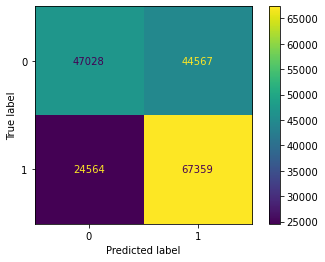

In [167]:
cm_nb = confusion_matrix(y_test,y_pred_nb)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm_nb,
                                 display_labels=model_nb.classes_)
cm_disp.plot()
plt.show()

In [168]:
TP = cm_nb[1, 1]
TN = cm_nb[0, 0]
FP = cm_nb[0, 1]
FN = cm_nb[1, 0]
print("TP: "+str(TP)+" TN: "+str(TN)+" FP: "+str(FP)+" FN: "+str(FN))
print("Accuracy: "+str(metrics.accuracy_score(y_test,y_pred_nb)))
print("Recall: "+str(metrics.recall_score(y_test,y_pred_nb)))
print("Specificity: "+str(TN/(TN+FP)))

TP: 67359 TN: 47028 FP: 44567 FN: 24564
Accuracy: 0.6233012565524908
Recall: 0.732776345419536
Specificity: 0.5134341394180905


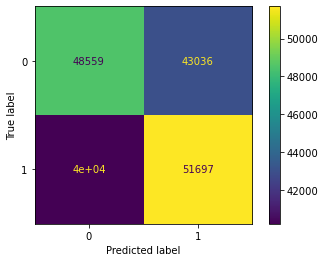

In [169]:
cm_lr = confusion_matrix(y_test,y_pred_lr)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm_lr,
                                 display_labels=model_lr.classes_)
cm_disp.plot()
plt.show()

In [170]:
TP = cm_lr[1, 1]
TN = cm_lr[0, 0]
FP = cm_lr[0, 1]
FN = cm_lr[1, 0]
print("TP: "+str(TP)+" TN: "+str(TN)+" FP: "+str(FP)+" FN: "+str(FN))
print("Accuracy: "+str(metrics.accuracy_score(y_test,y_pred_lr)))
print("Recall: "+str(metrics.recall_score(y_test,y_pred_lr)))
print("Specificity: "+str(TN/(TN+FP)))

TP: 51697 TN: 48559 FP: 43036 FN: 40226
Accuracy: 0.5463006353600192
Recall: 0.5623946128825212
Specificity: 0.5301490256018342


In [171]:
alert()

## Codes below for problem no 3: clustering cabs
The cabs will be clustered by total rides miles vs idle miles

In [172]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from k_means_constrained import KMeansConstrained

In [173]:
cluster_data = cab_rides.append(cab_idles).groupby('cab_id').mean()

In [174]:
cluster_data.tail()

,rides_miles,idle_miles
cab_id,,
uvburki,84.572329,67.828332
uvigcho,103.222959,75.913279
uvjeahot,82.311077,73.248251
uvjova,74.485996,60.789323
uvreoipy,86.553048,74.665302


<AxesSubplot:xlabel='rides_miles', ylabel='idle_miles'>

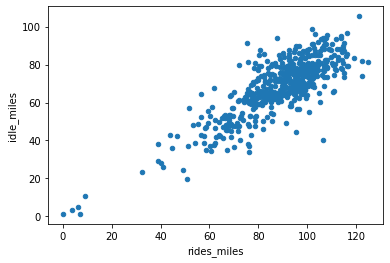

In [175]:
cluster_data.plot.scatter(x='rides_miles',y='idle_miles')

In [176]:
import matplotlib.pyplot as plt

In [177]:
cluster_array = np.array(cluster_data)

In [178]:
print(cluster_array)

[[ 81.93266763  63.24774793]
 [  6.28953653   5.07955327]
 [104.55233507  91.92900974]
 ...
 [ 82.31107723  73.24825141]
 [ 74.48599628  60.789323  ]
 [ 86.55304755  74.66530178]]


In [179]:
scaler = MinMaxScaler()

In [180]:
cluster_array_scaled = scaler.fit_transform(cluster_array)
cluster_array_scaled

array([[0.65594365, 0.5950626 ],
       [0.04796198, 0.03663522],
       [0.83774923, 0.87040899],
       ...,
       [0.65898512, 0.69106962],
       [0.59609103, 0.57146119],
       [0.69307996, 0.70467362]])

In [181]:
len(cluster_array)

537

In [182]:
kmeans = KMeansConstrained(n_clusters=7, size_min=76, size_max=90, random_state=0)

In [183]:
kmeans.fit_predict(cluster_array_scaled)

array([2, 5, 0, 3, 6, 1, 0, 1, 4, 3, 2, 5, 6, 2, 2, 2, 0, 1, 1, 0, 6, 6,
       2, 4, 4, 1, 1, 6, 4, 3, 3, 4, 4, 5, 2, 5, 6, 3, 6, 4, 6, 2, 4, 4,
       1, 2, 3, 6, 1, 5, 3, 0, 1, 6, 5, 2, 3, 1, 4, 4, 3, 3, 3, 4, 2, 4,
       5, 6, 5, 1, 6, 0, 1, 3, 0, 3, 6, 0, 4, 3, 0, 4, 4, 6, 6, 5, 4, 3,
       1, 4, 1, 5, 3, 5, 6, 1, 2, 1, 2, 1, 3, 1, 6, 6, 2, 6, 6, 0, 1, 5,
       3, 4, 4, 5, 0, 2, 1, 3, 1, 0, 1, 2, 5, 3, 3, 0, 4, 3, 4, 2, 6, 2,
       6, 3, 6, 0, 1, 3, 0, 1, 1, 0, 3, 1, 4, 5, 4, 0, 3, 1, 0, 1, 6, 5,
       0, 1, 6, 4, 1, 3, 5, 5, 2, 5, 4, 5, 1, 5, 5, 1, 5, 1, 5, 0, 0, 0,
       2, 3, 5, 0, 3, 0, 6, 5, 1, 3, 5, 2, 6, 6, 2, 4, 0, 5, 0, 0, 3, 2,
       6, 2, 3, 5, 4, 2, 0, 3, 6, 0, 1, 6, 4, 2, 3, 3, 3, 2, 0, 3, 2, 0,
       5, 0, 2, 0, 3, 5, 5, 0, 5, 0, 4, 5, 4, 1, 0, 3, 4, 6, 1, 5, 3, 2,
       6, 2, 2, 2, 4, 5, 1, 4, 0, 2, 2, 3, 1, 6, 5, 0, 5, 1, 2, 1, 4, 1,
       6, 2, 5, 5, 0, 1, 5, 3, 3, 5, 5, 1, 0, 3, 2, 6, 1, 0, 5, 1, 1, 5,
       2, 6, 4, 3, 3, 0, 4, 4, 4, 4, 3, 2, 3, 2, 3,

In [184]:
print(kmeans.cluster_centers_)

[[0.87766216 0.81649024]
 [0.68919976 0.63685755]
 [0.62776844 0.55320734]
 [0.80950158 0.7218099 ]
 [0.72232567 0.76050394]
 [0.46330345 0.38565242]
 [0.77994622 0.6244596 ]]


In [185]:
cluster_data['cluster'] = kmeans.labels_

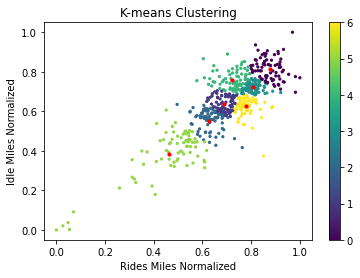

In [186]:
output = plt.scatter(cluster_array_scaled[:,0], cluster_array_scaled[:,1], s = 5, c = cluster_data.cluster, marker = "o", alpha = 1)
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=10, alpha=1 , marker='o')
plt.title('K-means Clustering')
plt.xlabel('Rides Miles Normalized')
plt.ylabel('Idle Miles Normalized')
plt.colorbar(output)
plt.show()

In [187]:
cluster_map = pd.DataFrame()
cluster_map['cab_id'] = cluster_data.index.values
cluster_map['cluster'] = kmeans.labels_

In [188]:
cluster_map.groupby('cluster')['cab_id'].count()

cluster
0    76
1    76
2    76
3    81
4    76
5    76
6    76
Name: cab_id, dtype: int64

# End of code